In [1]:
include("../src/models.jl")
include("../src/special.jl")
include("../src/solvers.jl")

using Plots; pyplot()
using JLD
using Logging
using Distributions
using DSP
using LaTeXStrings
using RollingFunctions
using Dierckx

In [145]:
p = 1000
N = 120
ω = 1.0
ρ = 0.05
τ = 0.5
β = 0.27
T = 15
σ = 1.0

# Discretization
Δx = 0.05
Δt = 0.05
x_disc = Array{Float64}(-6:Δx:6)
t_disc = Array{Float64}(0:Δt:T)

M = size(x_disc)[1]
N = size(t_disc)[1]

# Differential operator
D = zeros(M, M)

for i ∈ 2:M-1
    D[i, i-1:i] = [-1, 1]
end
D /= Δx

init = Normal(1/sqrt(2), 1/2)
ξ = 1/sqrt(ρ)

# ϕ(x) = β*sgn(x);
ϕ(x) = 0
Γ(x, ξ, Qt, Rt) = τ*ω*Qt*ξ - ϕ(x) - x*(τ*ω*Qt^2 - Rt + (τ^2/2)*(1+ω*Qt^2))

Γ (generic function with 1 method)

In [146]:
P = zeros(N, M)
P[1, :] = pdf.(init, x_disc)
Qs = zeros(N)
ϕx = ϕ.(x_disc)

for t ∈ 2:N
    Pt = P[t-1,:]
    Rt = dot(x_disc.*ϕx, Pt)*Δx
    Qt = sqrt(ρ)*dot(x_disc, Pt)*Δx
    G = Γ.(x_disc, ξ, Qt, Rt)
    
    dPdx = D*(Pt.*G)
    ddPdx = (D*D)*Pt
    
    dPdt = -dPdx .+ τ^2*(1+ω*Qt^2)*ddPdx/2
    P[t,:] = filtfilt(myfilter, Pt .+ Δt*dPdt)
    Qs[t-1] = Qt
end
Qs[end] = Qs[end-1];

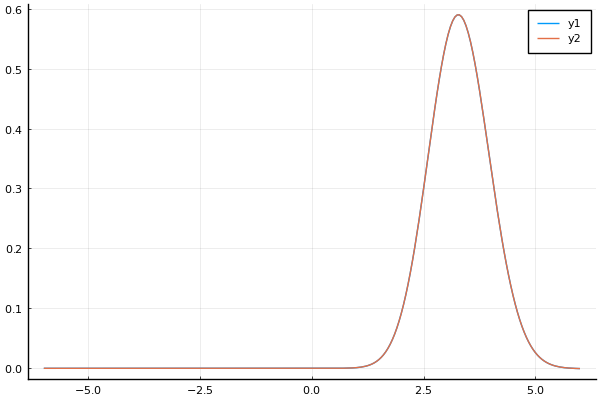

In [147]:
myfilter = digitalfilter(Lowpass(0.25), Butterworth(2))
Pt = P[145, :]
filtP = filtfilt(myfilter, Pt)

plt = plot(x_disc, filtP)
plot!(plt, x_disc, Pt)

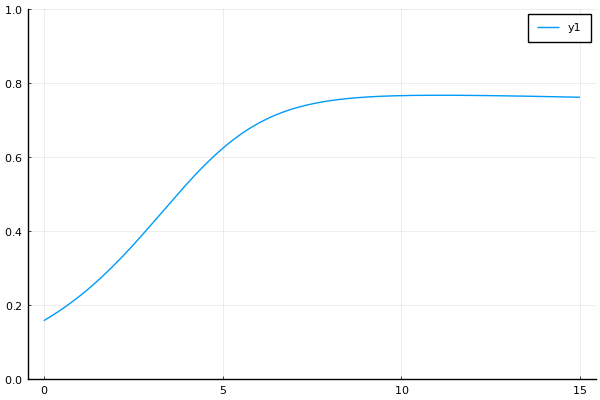

In [148]:
plot(t_disc, Qs, ylim=(0, 1))